# Prediction Of Singapore HDB Prices

## Preparation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
import csv
warnings.filterwarnings('ignore')

### Read Csv into data frame

In [2]:
df = pd.read_csv("../data/train.csv")
df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892


## Data cleaning and feature selection

### Check shape, nulls, zeroes and data type

In [3]:
def check_dataframe_shape_null_zeroes(df):
    print(f"Data frame shape: {df.shape}")
    print("\n")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    print("\n")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    print("\n")

    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")
        print("\n")
check_dataframe_shape_null_zeroes(df)

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

In [4]:
len(df['full_flat_type'].unique())

43

In [5]:
len(df['flat_model'].unique())

20

In [6]:
df.groupby("flat_type")['flat_model'].value_counts()

flat_type         flat_model            
1 ROOM            Improved                     82
2 ROOM            Model A                     739
                  Standard                    594
                  Improved                    521
                  Premium Apartment            37
                  2-room                        4
                  DBSS                          1
3 ROOM            New Generation            15227
                  Improved                  10240
                  Model A                    8454
                  Standard                   2522
                  Simplified                 1930
                  Premium Apartment           417
                  DBSS                        184
                  Terrace                      86
4 ROOM            Model A                   35127
                  New Generation             8139
                  Premium Apartment          7667
                  Simplified                 5309
         

### Feature Engineering

In [7]:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

### Imputation of null values

In [8]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

### Manual splitting into categories and numerical features

In [9]:
numerical_columns = []
categorical_columns = []
filename = "../data/data_dictionary_analysis.csv"
data_dict = pd.read_csv(filename)
with open(filename,'r') as data:
    reader = csv.reader(data)
    next(reader, None)  # skip the headers
    for line in reader:
        if line[3]=='1' and line[4] == 'numerical':
            numerical_columns.append(line[1])
        if line[3]=='1' and line[4] == 'Categorical':
            categorical_columns.append(line[1])

pd.set_option('display.max_colwidth', None)
data_dict = data_dict.loc[data_dict['X']==1][['Feature','Description','Data type','Missing Data']]
data_dict

,Feature,Description,Data type,Missing Data
3,flat_type,"type of the resale flat unit, e.g. 3 ROOM",Categorical,NaN
7,floor_area_sqm,floor area of the resale flat unit in square metres,numerical,NaN
8,flat_model,"HDB model of the resale flat, e.g. Multi Generation",Categorical,NaN
10,Tranc_Year,year of resale transaction,Categorical,NaN
15,mid,middle value of storey_range,numerical,NaN
20,max_floor_lvl,highest floor of the resale flat,numerical,NaN
43,planning_area,Government planning area that the flat is located,Categorical,NaN
54,mrt_nearest_distance,distance (in metres) to the nearest MRT station,numerical,NaN
76,hdb_age_at_tranc,hdb age during the transaction date,numerical,NaN


### Check data types

In [10]:
for i in numerical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}]")
    
for i in categorical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}] has unique counts [{len(set(df[i]))}]")

Column [floor_area_sqm] has data type [float64]
Column [mid] has data type [int64]
Column [max_floor_lvl] has data type [int64]
Column [mrt_nearest_distance] has data type [float64]
Column [hdb_age_at_tranc] has data type [int64]
Column [flat_type] has data type [object] has unique counts [7]
Column [flat_model] has data type [object] has unique counts [20]
Column [Tranc_Year] has data type [int64] has unique counts [10]
Column [planning_area] has data type [object] has unique counts [32]


## EDA

### Correlation heat map of numerical columns

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'mid'),
  Text(2.5, 0, 'max_floor_lvl'),
  Text(3.5, 0, 'mrt_nearest_distance'),
  Text(4.5, 0, 'hdb_age_at_tranc'),
  Text(5.5, 0, 'resale_price')])

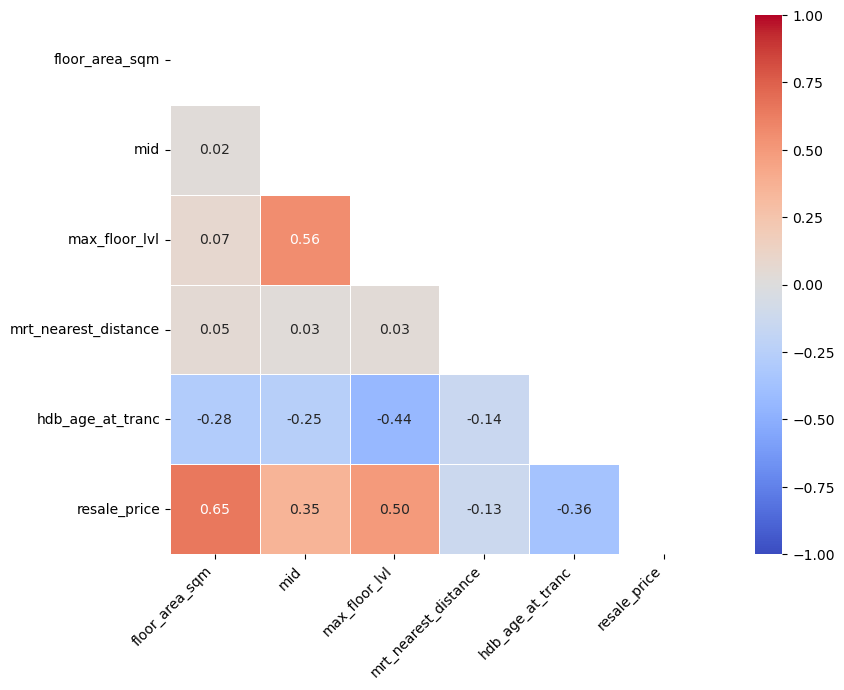

In [11]:
# Use Seaborn's heatmap with pandas .corr() to visualize correlations between all numeric features.
corr = df[numerical_columns+['resale_price']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

### Bar charts for categorical features

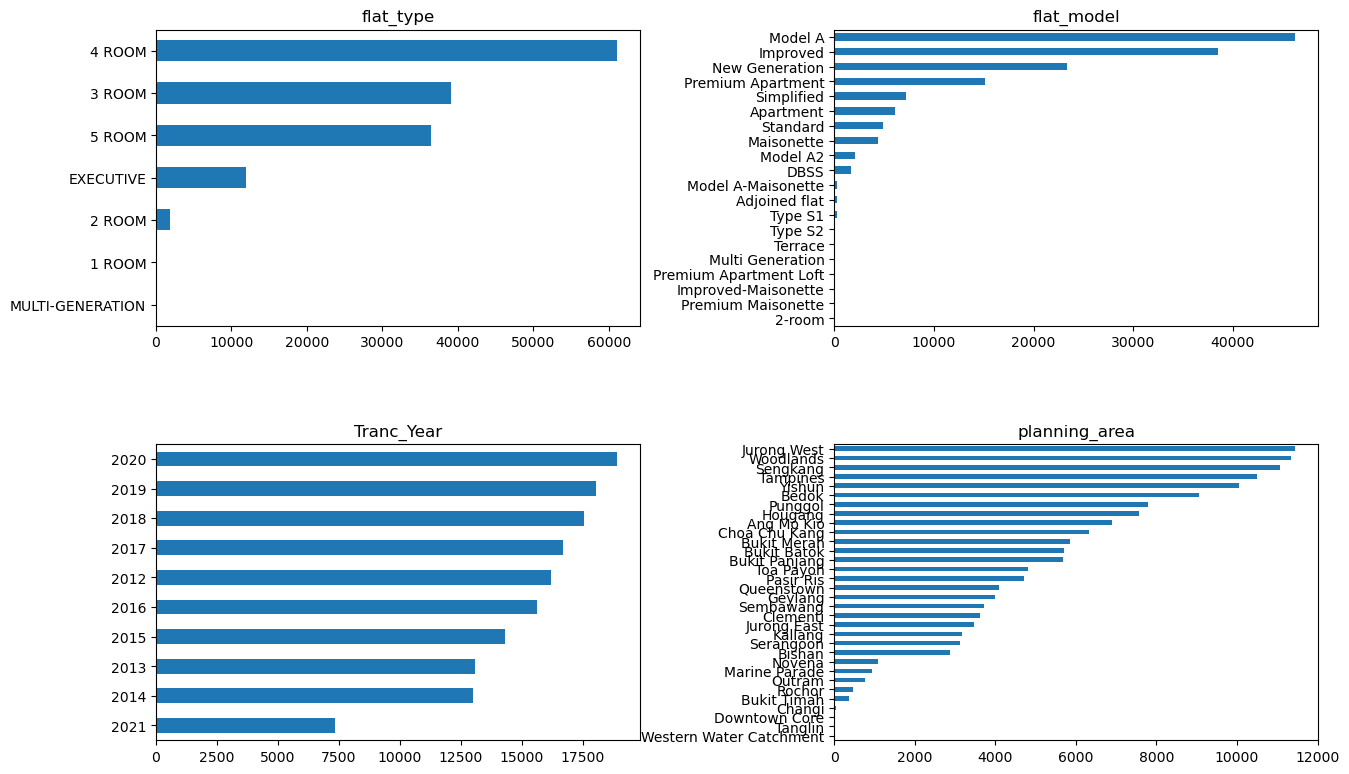

In [12]:
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(categorical_columns):
    fig1.add_subplot(4,2,idx+1)
    df[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

### Histogram for numerical features

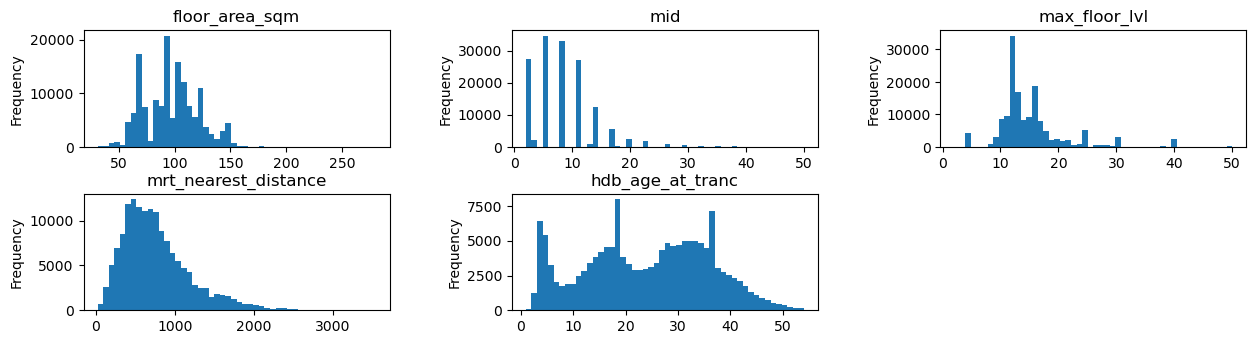

In [13]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig1b.add_subplot(5,3,idx+1)
    df[d].plot(kind='hist',bins=50,title=d)

### Box plots for outliers

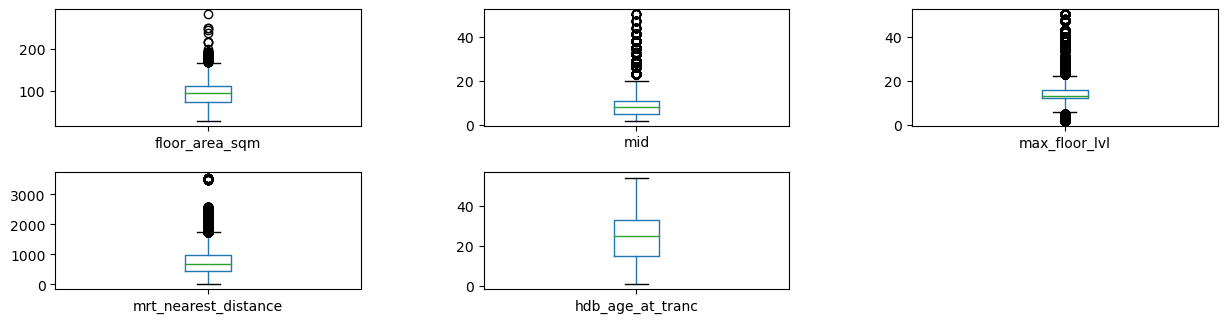

In [14]:
# Plot and interpret boxplots
fig2 = plt.figure(figsize=(15,10))
fig2.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig2.add_subplot(5,3,idx+1)
    bp = df.boxplot(column=d, grid=False)

### Scatter plots by Flat types

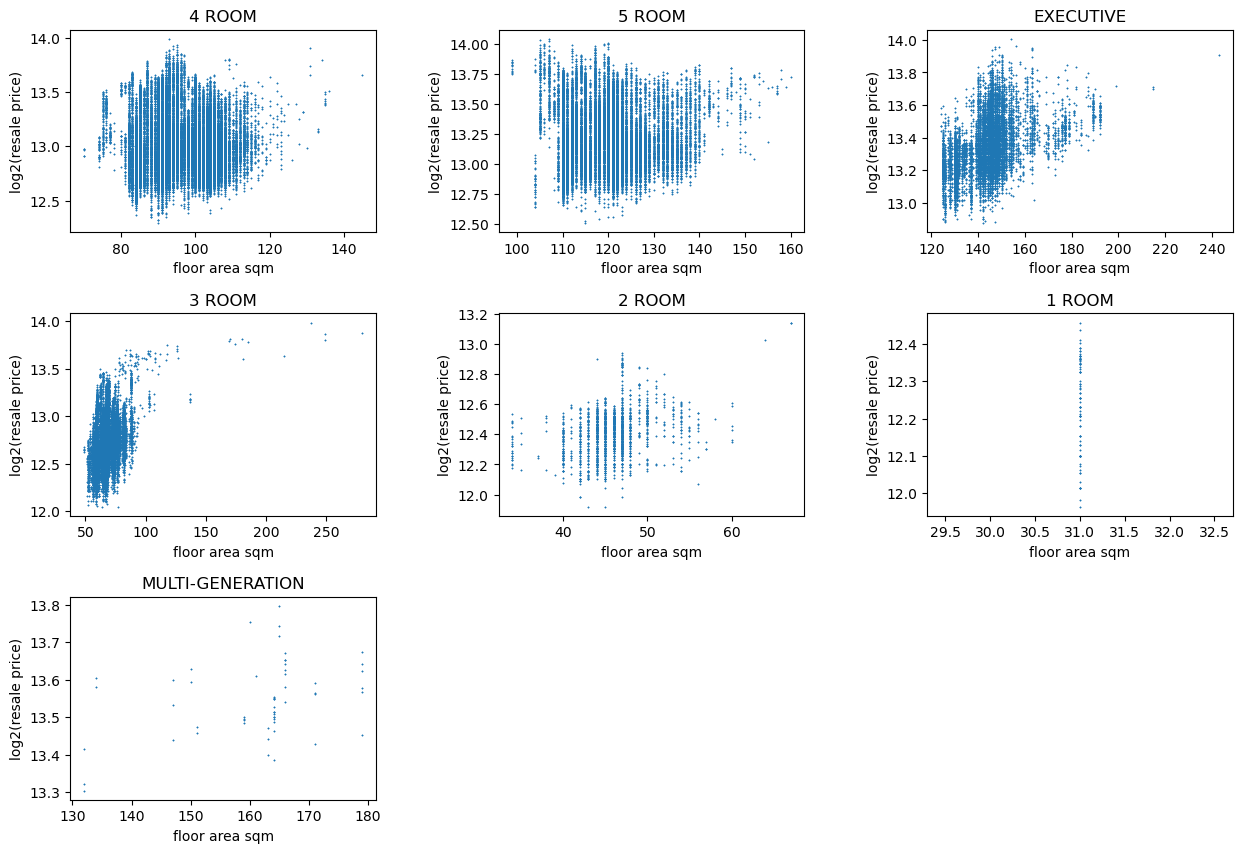

In [15]:
fig3 = plt.figure(figsize=(15,10))
fig3.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(df['flat_type'].unique()):
    x = df.loc[df['flat_type']==d]['floor_area_sqm']
    y = np.log(df.loc[df['flat_type']==d]['resale_price'])
    fig3.add_subplot(3,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('log2(resale price)')
    plt.title(d)

### Scatter plots by Planning area

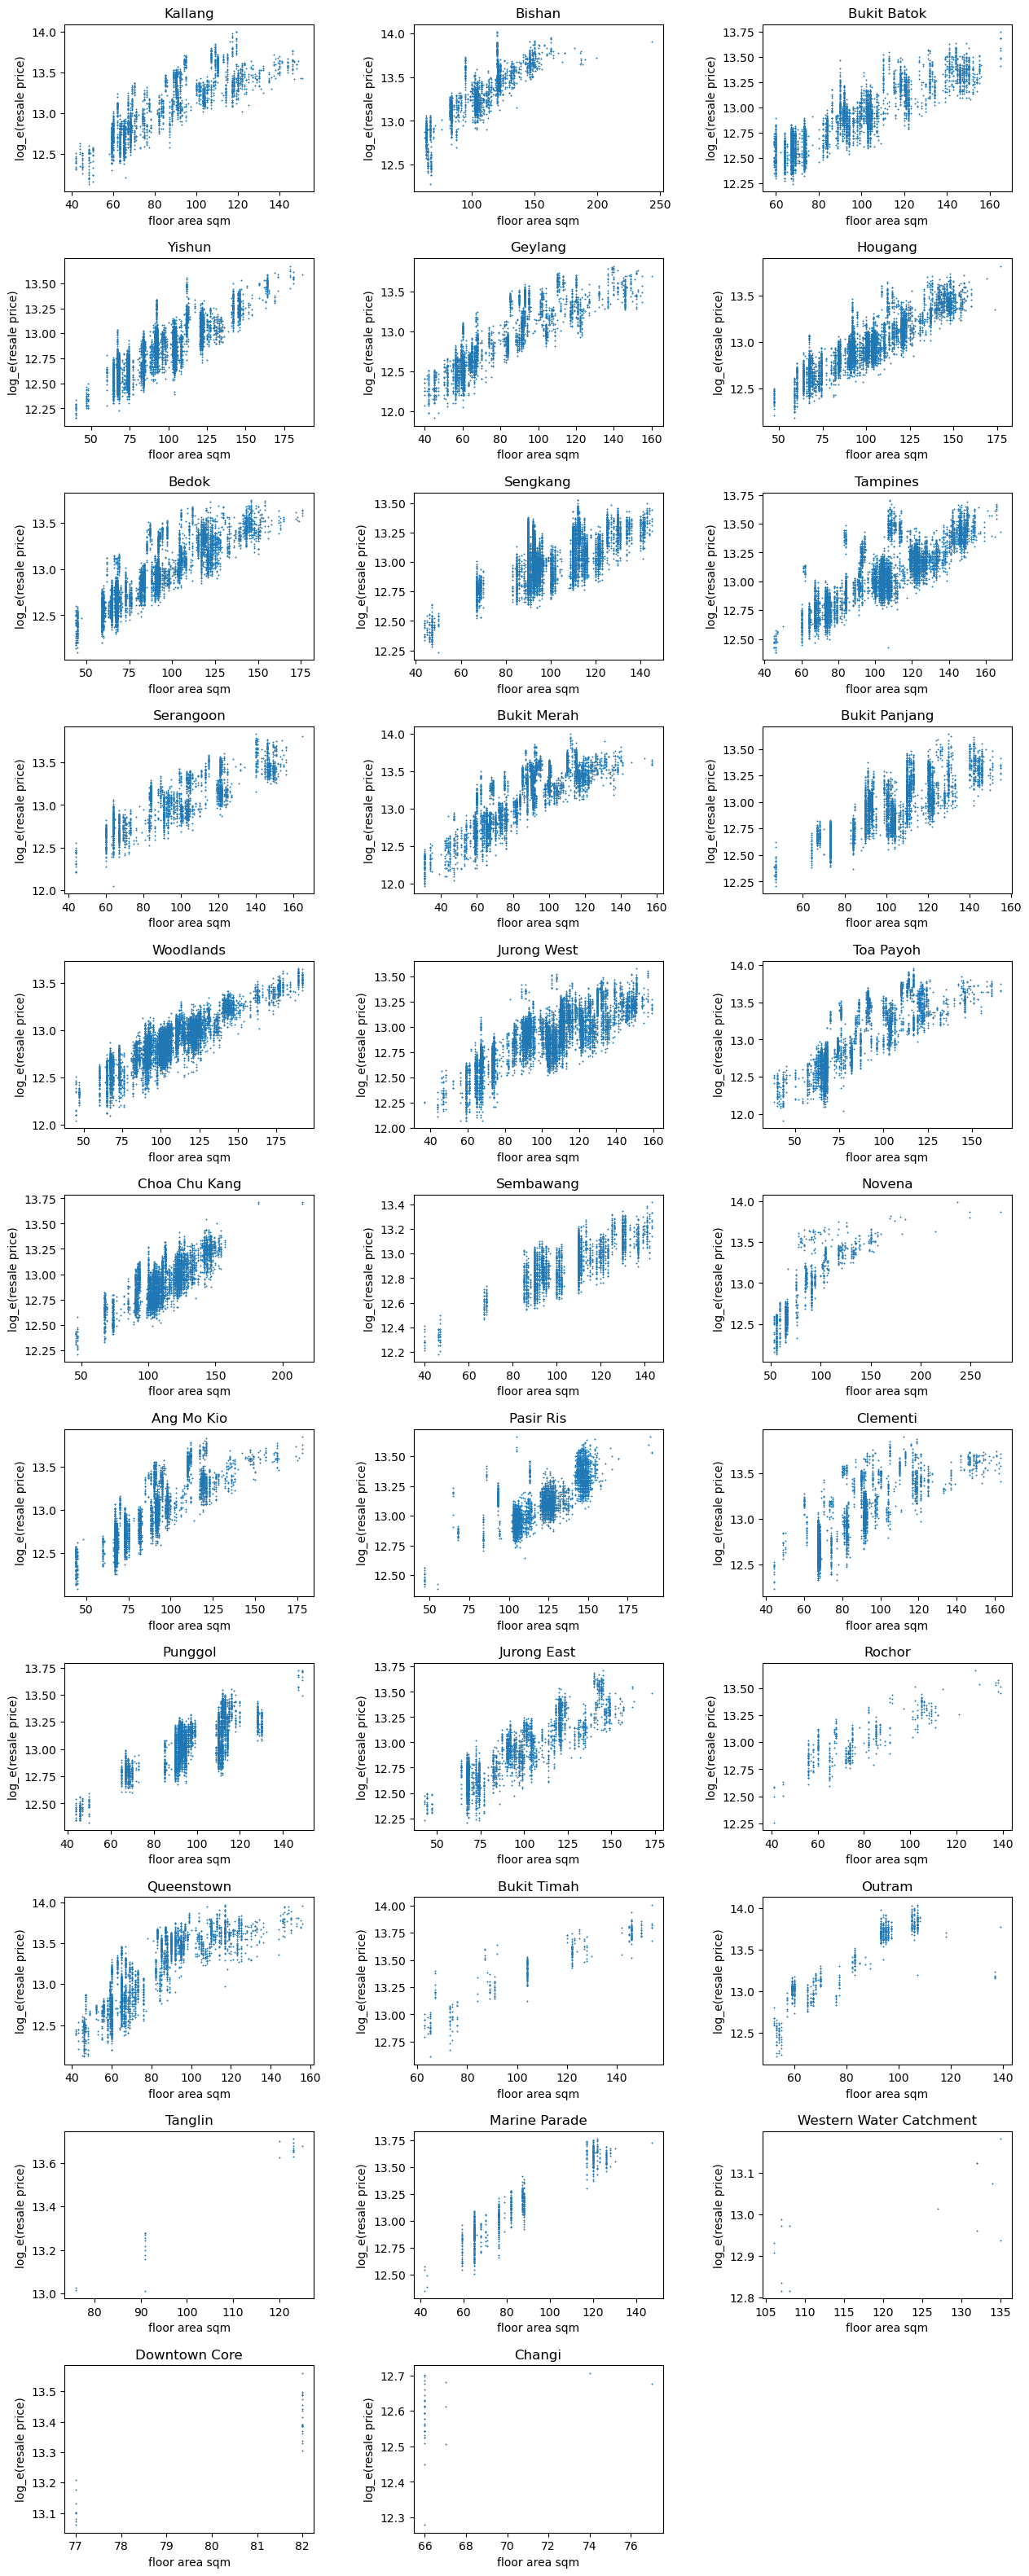

In [16]:
fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)

indicator = 'planning_area'
for idx, d in enumerate(df[indicator].unique()):
    x = df.loc[(df[indicator]==d)]['floor_area_sqm']
    y = np.log(df.loc[(df[indicator]==d)]['resale_price'])
    #x = df.loc[(df[indicator]==d) & (df['flat_type']=='4 ROOM')]['floor_area_sqm']
    #y = np.log(df.loc[(df[indicator]==d) & (df['flat_type']=='4 ROOM')]['resale_price'])
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('log_e(resale price)')
    plt.title(d)

## Feature Engineering and Selection

### Setup features and target. 
#### Use logarithm value of predicted value

In [17]:
X= df[numerical_columns+categorical_columns]
y= df['resale_price']

nulls = {k:v for k,v in dict(X.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")

### Train and Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

## Model Building

In [19]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [20]:
%%time
model = Ridge()
pipe = make_pipeline(preprocessor, model)
hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1,1,10]}
gs = GridSearchCV(pipe, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')
gs.fit(X_train,y_train)
print(f"Best Score: {-gs.best_score_}")
print(f"Best Params: {gs.best_params_}")

Best Score: 48616.86195000042
Best Params: {'ridge__alpha': 0.01}
CPU times: total: 15.7 s
Wall time: 14.3 s


In [21]:
results = pd.DataFrame(gs.cv_results_)
results.sort_values(['mean_test_score'],ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.491063,0.029194,0.076421,0.004320,0.01,{'ridge__alpha': 0.01},-48600.551851,-48446.389630,-48616.078198,-48760.931706,-48660.358365,-48616.861950,101.956342,1
0,0.508728,0.016412,0.072676,0.007219,0.001,{'ridge__alpha': 0.001},-48598.853344,-48446.356866,-48616.050918,-48766.941391,-48660.142221,-48617.668948,103.721469,2
2,0.437858,0.036051,0.064584,0.004443,0.1,{'ridge__alpha': 0.1},-48600.246975,-48446.934488,-48616.142787,-48766.554431,-48660.345393,-48618.044815,103.386237,3
3,0.429432,0.008823,0.058307,0.001849,1,{'ridge__alpha': 1},-48598.359115,-48452.124210,-48617.187974,-48762.287377,-48661.858559,-48618.363447,100.640907,4
4,0.518198,0.040502,0.070295,0.004732,10,{'ridge__alpha': 10},-48613.780537,-48545.111139,-48668.881598,-48752.891487,-48712.156429,-48658.564238,73.148323,5


## Model Evaluation

In [22]:
# evaluation metric R2, instead of Root Mean Square Error (RMSE)
predicted = gs.best_estimator_.predict(X_test)
mse = metrics.mean_squared_error(y_test, predicted)
print(f"Test score = {np.sqrt(mse):.3f}")
print("The mean cross-validation rmse is: "
      f"{-results['mean_test_score'].mean():.3f} ± {results['std_test_score'].mean():.3f}")

Test score = 48342.965
The mean cross-validation rmse is: 48625.901 ± 96.571


In [23]:
coefficients = gs.best_estimator_[1].coef_
out_columns_numerical = gs.best_estimator_[0].transformers_[1][2]
out_columns_category = list(gs.best_estimator_[0].transformers_[0][1].get_feature_names())
out_columns = out_columns_category+out_columns_numerical
out_columns

['x0_1 ROOM',
 'x0_2 ROOM',
 'x0_3 ROOM',
 'x0_4 ROOM',
 'x0_5 ROOM',
 'x0_EXECUTIVE',
 'x0_MULTI-GENERATION',
 'x1_2-room',
 'x1_Adjoined flat',
 'x1_Apartment',
 'x1_DBSS',
 'x1_Improved',
 'x1_Improved-Maisonette',
 'x1_Maisonette',
 'x1_Model A',
 'x1_Model A-Maisonette',
 'x1_Model A2',
 'x1_Multi Generation',
 'x1_New Generation',
 'x1_Premium Apartment',
 'x1_Premium Apartment Loft',
 'x1_Premium Maisonette',
 'x1_Simplified',
 'x1_Standard',
 'x1_Terrace',
 'x1_Type S1',
 'x1_Type S2',
 'x2_2012',
 'x2_2013',
 'x2_2014',
 'x2_2015',
 'x2_2016',
 'x2_2017',
 'x2_2018',
 'x2_2019',
 'x2_2020',
 'x2_2021',
 'x3_Ang Mo Kio',
 'x3_Bedok',
 'x3_Bishan',
 'x3_Bukit Batok',
 'x3_Bukit Merah',
 'x3_Bukit Panjang',
 'x3_Bukit Timah',
 'x3_Changi',
 'x3_Choa Chu Kang',
 'x3_Clementi',
 'x3_Downtown Core',
 'x3_Geylang',
 'x3_Hougang',
 'x3_Jurong East',
 'x3_Jurong West',
 'x3_Kallang',
 'x3_Marine Parade',
 'x3_Novena',
 'x3_Outram',
 'x3_Pasir Ris',
 'x3_Punggol',
 'x3_Queenstown',
 'x3

In [24]:
len(out_columns)

74

In [25]:
len(coefficients)

74

In [26]:
sorted(list(zip(np.round(coefficients,3),out_columns)),key=lambda x: abs(x[0]),reverse=True)

[(354538.215, 'x1_Terrace'),
 (205571.006, 'x3_Marine Parade'),
 (164893.259, 'x3_Bukit Timah'),
 (-163078.93, 'x3_Sembawang'),
 (-143943.825, 'x3_Choa Chu Kang'),
 (-136257.227, 'x3_Woodlands'),
 (113303.364, 'x3_Changi'),
 (-103551.346, 'x3_Bukit Panjang'),
 (-99943.66, 'x3_Jurong West'),
 (96352.868, 'x3_Tanglin'),
 (95700.198, 'x1_Type S2'),
 (95230.531, 'x3_Bishan'),
 (-94664.167, 'x3_Sengkang'),
 (87445.04, 'x3_Bukit Merah'),
 (-87208.758, 'x1_Model A'),
 (-86836.424, 'x1_Improved'),
 (-85434.719, 'x1_Model A2'),
 (84429.474, 'floor_area_sqm'),
 (83898.031, 'x3_Outram'),
 (-82734.431, 'x3_Punggol'),
 (-80556.29, 'x1_Premium Apartment'),
 (78846.154, 'x3_Queenstown'),
 (77314.783, 'x3_Downtown Core'),
 (-75379.912, 'x3_Yishun'),
 (-73041.038, 'x1_Simplified'),
 (-71767.285, 'x1_New Generation'),
 (-67742.6, 'x1_Standard'),
 (-66347.173, 'x3_Bukit Batok'),
 (-61961.751, 'x3_Pasir Ris'),
 (-55316.904, 'x1_Apartment'),
 (-46678.681, 'x3_Jurong East'),
 (-46630.511, 'x3_Hougang'),
 (-

## Prediction

In [27]:
test_df = pd.read_csv("../data/test.csv")
test_df.head(5)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,40303,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,...,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430
3,109506,2017-10,WOODLANDS,4 ROOM,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,...,54,0,1.434423,103.773698,433.454591,Woodlands Secondary School,188,0,1.439183,103.774499
4,100149,2016-08,BUKIT BATOK,4 ROOM,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,...,40,0,1.349195,103.741000,217.295361,Bukit Batok Secondary School,223,0,1.348351,103.740873


In [28]:
check_dataframe_shape_null_zeroes(test_df)

Data frame shape: (16737, 76)


Empty rows in column [Mall_Nearest_Distance]: 84
Empty rows in column [Mall_Within_500m]: 10292
Empty rows in column [Mall_Within_1km]: 2786
Empty rows in column [Mall_Within_2km]: 213
Empty rows in column [Hawker_Within_500m]: 10755
Empty rows in column [Hawker_Within_1km]: 6729
Empty rows in column [Hawker_Within_2km]: 3254


Rows with zeroes in column [1room_sold]: 16730
Rows with zeroes in column [2room_sold]: 16027
Rows with zeroes in column [3room_sold]: 10607
Rows with zeroes in column [4room_sold]: 3297
Rows with zeroes in column [5room_sold]: 7002
Rows with zeroes in column [exec_sold]: 13916
Rows with zeroes in column [multigen_sold]: 16727
Rows with zeroes in column [studio_apartment_sold]: 16592
Rows with zeroes in column [1room_rental]: 16711
Rows with zeroes in column [2room_rental]: 16516
Rows with zeroes in column [3room_rental]: 16319
Rows with zeroes in column [other_room_rental]: 16736
Rows with zeroes in column [Mall_Nearest_Distance]

In [29]:
test_df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

In [30]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(test_df[i])
    test_df[i].fillna(value=mean, inplace=True)

In [31]:
X_test_df = test_df[numerical_columns+categorical_columns]

In [32]:
pred = gs.best_estimator_.predict(X_test_df)
pred.shape

(16737,)

In [33]:
sub_df = pd.DataFrame()
sub_df["Id"] = test_df['id'] 
sub_df["Predicted"] = pred
sub_df.to_csv("../data/sub_reg.csv", index=False)

In [34]:
sub_df.head()

,Id,Predicted
0,114982,436541.577285
1,95653,455417.827548
2,40303,449693.088261
3,109506,320103.931925
4,100149,454683.993097


In [35]:
sub_df.shape

(16737, 2)